# Jupyter Notebook demonstrating Welday _et al._ (2011)
[Cosine Directional Tuning of Theta Cell Burst Frequencies: Evidence for Spatial Coding by Oscillatory Interference](http://www.jneurosci.org/content/31/45/16157.long)

In [1]:
import numpy as np
import numpy.random as nprd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import LineCollection
import math

import vco

%matplotlib inline

## VCO Matrix and DBFT curves
We establish and initialize the VCO matrix shown in Figure 7. We then show various tuning curves, which are analogous to the directional burst frequency-tuning (DBFT) curves shown in Figures 1-6, 8. 

First, we'll initialize the 6-by-12 VCO matrix from Figure 7:

In [2]:
N = 12
numrow = 6; numcol = 12;

rhos = 0.14 * (np.sqrt(3) ** np.arange(numrow))
thetas = np.pi + 2.0*np.pi*(np.arange(numcol))/numcol


VCOmatrix = [[vco.VCO_model(N, rhos[i], thetas[j]) for j in range(numcol)] for i in range(numrow)]

Then, we create a velocity vector (path) to serve as input to the VCOs:

In [3]:
# Create a simulated running path (constant velocity, running around in a circle)
d = np.arange(0, 2 * np.pi, 0.001)
v = 2*np.ones_like(d)
pol_path = np.asarray([v,d]).T
x = v * np.cos(d)
y = v * np.sin(d)

Then, we calculate and plot the tuning curves (analogous to DBFT curves) for each cell in the "first" VCO (i.e. $[\rho,\theta] = [0.14,\pi]$).

In [4]:
# Create tuning curves by calculating angular frequency
tune = np.zeros((d.shape[0],N))
for cell in range(N):
    tune[:,cell] = VCOmatrix[0][0].get_angular_freq(cell, pol_path)

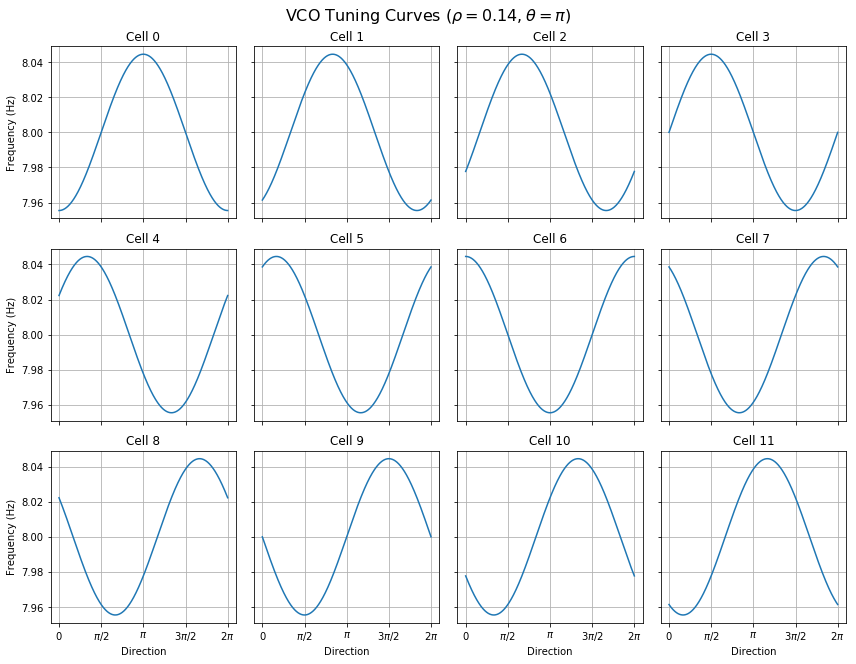

In [5]:
# Plot the tuning curves
fig, axs = plt.subplots(3,4,sharex=True,sharey=True,figsize=(12,9))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for cell in range(N):
    axs[cell].plot(d,tune[:,cell])
    axs[cell].set_title('Cell %d' % cell)
    axs[cell].grid()
    
    if not (cell) % 4:
        axs[cell].set_ylabel('Frequency (Hz)')
    if cell >= 8:
        axs[cell].set_xlabel('Direction')
        axs[cell].set_xticks([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
        axs[cell].set_xticklabels(["$0$", "$\pi/2$", "$\pi$","$3\pi/2$", "$2 \pi$"]);

plt.tight_layout()
plt.suptitle(r"VCO Tuning Curves ($\rho = 0.14, \theta = \pi$)",fontsize=16,y=1.02);

We can also visualize the activity of the entire VCO at a particular timestep to see how the module acts as a bump attractor (like the head-direction cell on which it is based):

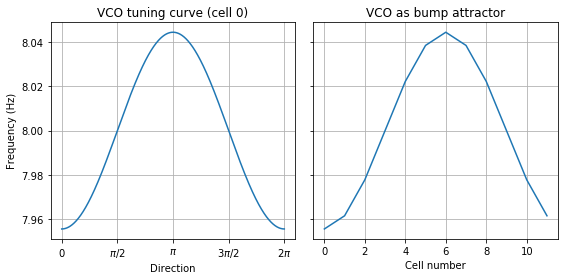

In [6]:
fig, axs = plt.subplots(1,2,sharey=True,figsize=(8,4))
axs[0].set_title('VCO tuning curve (cell 0)')
axs[0].plot(pol_path[:,1], tune[:,0])
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xlabel('Direction')
axs[0].set_xticks([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
axs[0].set_xticklabels(["$0$", "$\pi/2$", "$\pi$","$3\pi/2$", "$2 \pi$"])
axs[0].grid()

axs[1].set_title('VCO as bump attractor')
axs[1].plot(np.arange(N),tune[0,:])
axs[1].set_xlabel('Cell number')
axs[1].grid()

plt.tight_layout()

## Forming Hippocampal Nav. Cells from VCOs

Now, using the matrix from Figure 7 defined above, we can demonstrate all of the cells shown in the paper and supplemental material (Figures 7 and 9). The weight matrices plotted here correspond in organization to that in Figure 7. By creating 2D random walks, we can also show the response of a cell over a realistic path, rather than only the ideal response over the entire arena.

In [7]:
ss = np.linspace(-5,5,50)
xx, yy = np.meshgrid(ss,ss)

Define weight matrices for all the example cells from the paper:

In [8]:
# border cell (Fig. 7)
weights_border = np.full([6,12],np.nan)
weights_border[:,9] = [2,3,5,7,11,9]

# large grid (Fig. 7)
weights_lgrid = np.full([6,12],np.nan)
weights_lgrid[3,0] = 9
weights_lgrid[3,4] = 9
weights_lgrid[3,8] = 3

# small grid (Fig. 7)
weights_sgrid = np.full([6,12],np.nan)
weights_sgrid[3,1] = 1
weights_sgrid[3,5] = 9
weights_sgrid[3,9] = 3

# place cell (Fig. 7)
weights_place = np.full([6,12],np.nan)
rot_place = 8*np.pi/6. #orientation of the tuning function is zero by default
weights_place[2,:] = [11,11,0,0,0,0,0,0,11,10,10,10]
weights_place[3,:] = [10,11,0,0,0,0,0,0,10,10,10,10]
weights_place[4,:] = [10,11,0,1,2,1,0,0,10, 9, 8, 9]

# curved border (Fig. 9)
weights_cborder = np.full([6,12],np.nan)
for col in [0,1,2,3,4,11]:
    weights_cborder[:,col] = [1,1,2,4,7,1]
    
#lumpy border (supplemental)
weights_lborder = np.full([6,12],np.nan)
weights_lborder[:,0] = [1,2,3,5,8,3]
weights_lborder[2,2] = 6
weights_lborder[3,2] = 1

# multi-field dentate place cell in square box (supplemental)
weights_dplace = np.full([6,12],np.nan)
weights_dplace[2,:] = [8,0,1,1,7,4,2,7,8,8,4,2]
weights_dplace[3,:] = [3,0,3,0,5,0,1,4,5,9,9,11]
weights_dplace[4,:] = [0,2,2,10,7,0,0,5,6,2,6,4]

In [9]:
N=75000
path = vco.randwalk(5,N,10)

In [10]:
lgrid_norm, lgrid_env = vco.matrix_sum(VCOmatrix, weights_lgrid, 5)

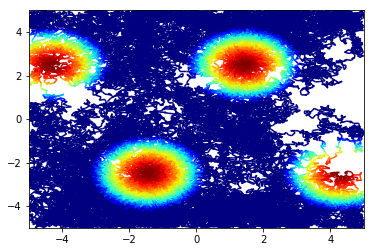

In [11]:
vco.plot_randwalk(path, vco.matrix_sum_rw(VCOmatrix, weights_lgrid, path))

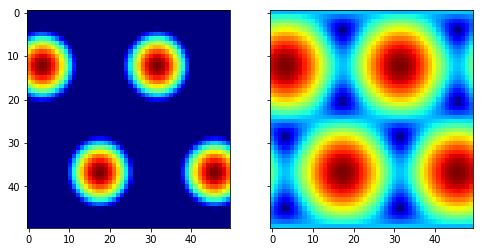

In [12]:
fig, axs = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,4))
axs[0].imshow(lgrid_norm, aspect='auto', cmap='jet')
axs[1].imshow(lgrid_env, aspect='auto', cmap='jet')

#  HERE IS WHERE I LEFT OFF !!!!!!!!!!

## Adding Noise to intra-VCO Timing

In [13]:
VCO_reg = RingOscillator(12,0.14,0)
VCO_jitter = RingOscillator(12,0.14,0,1)

NameError: name 'RingOscillator' is not defined

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Noiseless: rho = 0.14, theta = 0')
plt.imshow(VCO_reg.ring_activity(path_pol), aspect='auto',cmap='jet',origin='lower')
plt.colorbar()
plt.subplot(122)
plt.title('Noisy: rho = 0.14, theta = 0')
plt.imshow(VCO_jitter.ring_activity(path_pol), aspect='auto',cmap='jet',origin='lower')
plt.colorbar()

## Demo: HC Nav Cells with intra-VCO Noise

In [ ]:
jitter=np.pi/6

VCO_matrix_noisy=[[],[],[],[],[],[]]
for row in range(6):
    for col in range(12):
        VCO_matrix_noisy[row].append(RingOscillator(12, rhos[row], thetas[col], jitter))

In [ ]:
weights_choice = 6

In [ ]:
weights_noisy = np.full([6,12],np.nan)

# border cell
if weights_choice == 1:
    weights_noisy[:,9] = [2,3,5,7,11,9]
# large grid
elif weights_choice == 2:
    weights_noisy[3,0] = 9; weights_noisy[3,4] = 9; weights_noisy[3,8] = 3
#small grid
elif weights_choice == 3:
    weights_noisy[3,1] = 1; weights_noisy[3,5] = 9; weights_noisy[3,9] = 3
#place cell
elif weights_choice == 4:
    rotation_angle = 8*np.pi/6. #orientation of the tuning function is zero by default
    weights_noisy[2,:] = [11,11,0,0,0,0,0,0,11,10,10,10]
    weights_noisy[3,:] = [10,11,0,0,0,0,0,0,10,10,10,10]
    weights_noisy[4,:] = [10,11,0,1,2,1,0,0,10, 9, 8, 9]
#curved border
elif weights_choice == 5:
    for col in [0,1,2,3,4,11]:
        weights_noisy[:,col] = [1,1,2,4,7,1]
#lumpy border
elif weights_choice == 6:
    weights_noisy[:,0] = [1,2,3,5,8,3]
    weights_noisy[2,2] = 6; weights_noisy[3,2] = 1
# multi-field dentate place cell in square box
elif weights_choice == 7:
    weights_noisy[2,:] = [8,0,1,1,7,4,2,7,8,8,4,2]
    weights_noisy[3,:] = [3,0,3,0,5,0,1,4,5,9,9,11]
    weights_noisy[4,:] = [0,2,2,10,7,0,0,5,6,2,6,4]

# Plot weights matrix
plot_weights(weights_noisy)

In [ ]:
Esum = np.zeros([50,50],dtype='complex128')
for row in range(weights_noisy.shape[0]):
    for col in range(weights_noisy.shape[1]):
        if (not np.isnan(weights_noisy[row,col])):
            cell_response = VCO_matrix[row][col].cell_activity_2(int(weights_noisy[row,col]), xx, yy)
            Esum = Esum + cell_response

Esum = abs(Esum)
Emax = np.max(Esum)
EE = Esum-0.65*Emax
EE[EE<0] = 0
Emax =np.max(EE)

Esum_noisy = np.zeros([50,50],dtype='complex128')
for row in range(weights_noisy.shape[0]):
    for col in range(weights_noisy.shape[1]):
        if (not np.isnan(weights_noisy[row,col])):
            cell_response = VCO_matrix_noisy[row][col].cell_activity_2(int(weights_noisy[row,col]), xx, yy)
            Esum_noisy = Esum_noisy + cell_response

Esum_noisy = abs(Esum_noisy)
Emax_noisy = np.max(Esum_noisy)
EE_noisy = Esum_noisy-0.65*Emax_noisy
EE_noisy[EE_noisy<0] = 0
Emax_noisy =np.max(EE_noisy)

plt.figure(figsize=(12,10))

plt.subplot(221)
plt.title('Envelope (Sum of Noiseless VCOs)')
plt.imshow(Esum,aspect='auto',cmap='jet',extent=(-5,5,-5,5))
plt.subplot(222)
plt.title('Noiseless "Firing rate" (thresholded envelope)')
plt.imshow(EE/Emax,extent=(-5,5,-5,5),aspect='auto',cmap='jet')

plt.subplot(223)
plt.title('Envelope (Sum of Noisy VCOs)')
plt.imshow(Esum_noisy,aspect='auto',cmap='jet',extent=(-5,5,-5,5))
plt.subplot(224)
plt.title('Noisy "Firing rate" (thresholded envelope)')
plt.imshow(EE_noisy/Emax_noisy,extent=(-5,5,-5,5),aspect='auto',cmap='jet')

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Theta cell tuning curve (noiseless)')
plt.plot(path_pol[:,1], VCO_matrix[5][4].cell_activity(5,path_pol), path_pol[:,1],np.ones_like(path_pol[:,1])*7)
plt.ylabel('Frequency (Hz)')
plt.xticks(np.arange(0,5/2*np.pi,np.pi/2))
plt.grid()

plt.subplot(222)
plt.title('VCO as bump attractor (noisy)')
plt.plot(range(12),VCO_matrix[5][4].ring_activity(path_pol)[:,280], range(12),np.ones(12)*7)
plt.xticks(np.arange(0,12,1))
plt.grid()


plt.subplot(223)
plt.title('(noiseless)')
plt.plot(path_pol[:,1], VCO_matrix_noisy[5][4].cell_activity(5,path_pol), path_pol[:,1],np.ones_like(path_pol[:,1])*7)
plt.xticks(np.arange(0,5/2*np.pi,np.pi/2))
plt.grid()
plt.ylabel('Frequency (Hz)')
plt.xlabel('Direction (rad)')

plt.subplot(224)
plt.title('(noisy)')
plt.xlabel('Cell number')
plt.xticks(np.arange(0,12,1))
plt.plot(range(12),VCO_matrix_noisy[5][4].ring_activity(path_pol)[:,280], range(12),np.ones(12)*7)
plt.grid()

plt.tight_layout()

## Random projections of VCOmatrix rows

In [ ]:
num_inputs = 3

w = np.full([6,12], np.nan)
random_cells = np.random.randint(12, size=num_inputs)
random_cols = np.arange(12)
np.random.shuffle(random_cols)

w_x = np.random.randint(6)
#w_x = 1
w_y = random_cols[:num_inputs]

for i in range(num_inputs):
    w[w_x, w_y[i]] = random_cells[i]

#plot_weights(w)

In [ ]:
Esum = np.zeros([50,50],dtype='complex128')
for row in range(w.shape[0]):
    for col in range(w.shape[1]):
        if (not np.isnan(w[row,col])):
            cell_response = VCO_matrix[row][col].cell_activity_2(int(w[row,col]), xx, yy)
            Esum = Esum + cell_response

Esum = abs(Esum)
Emax = np.max(Esum)
EE = Esum-0.65*Emax
EE[EE<0] = 0
Emax =np.max(EE)

plt.figure(figsize=(18,6))


plt.subplot(131)
(x_size, y_size) = w.shape
im = plt.imshow(w,cmap='jet',origin='lower')
ax = plt.gca()
plt.title('Weights Matrix')
ax.grid(which='both', color='lightgray', linestyle='-', linewidth=2)
ax.set_xticks(np.arange(-0.5,12,1))
ax.set_yticks(np.arange(-0.5,6,1))
ax.set_xticklabels(np.arange(0, 12, 1))
ax.set_yticklabels(np.arange(0, 6, 1))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
plt.colorbar(im, cax=cax)
plt.subplot(132)
plt.title('Envelope (Sum of Noiseless VCOs)')
plt.imshow(Esum,aspect='auto',cmap='jet',extent=(-5,5,-5,5))
plt.subplot(133)
plt.title('Noiseless "Firing rate" (thresholded envelope)')
plt.imshow(EE/Emax,extent=(-5,5,-5,5),aspect='auto',cmap='jet')

Higher $w_x$ values (corresponding to lower rows in the weights matrix) correspond to higher frequency grids. Higher $w_x$ values correspond to higher $\rho$ values, so these VCOs are more sensitive to velocity (I think...). By looking at a larger arena, we can see the gridness of the small $w_x$ values.

In [ ]:
size = 50

ss_big = np.linspace(-size,size,10*size)
xx_big, yy_big = np.meshgrid(ss_big,ss_big)
if w_x < 2:
    Esum = np.zeros([10*size,10*size],dtype='complex128')
    for row in range(w.shape[0]):
        for col in range(w.shape[1]):
            if (not np.isnan(w[row,col])):
                cell_response = VCO_matrix[row][col].cell_activity_2(int(w[row,col]), xx_big, yy_big)
                Esum = Esum + cell_response

    Esum = abs(Esum)
    Emax = np.max(Esum)
    EE = Esum-0.65*Emax
    EE[EE<0] = 0
    Emax =np.max(EE)

    plt.figure(figsize=(18,6))


    plt.subplot(131)
    (x_size, y_size) = w.shape
    im = plt.imshow(w,cmap='jet')
    ax = plt.gca()
    plt.title('Weights Matrix')
    ax.grid(which='both', color='lightgray', linestyle='-', linewidth=2)
    ax.set_xticks(np.arange(-0.5,12,1))
    ax.set_yticks(np.arange(-0.5,6,1))
    ax.set_xticklabels(np.arange(0, 12, 1))
    ax.set_yticklabels(np.arange(0, 6, 1))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.25)
    plt.colorbar(im, cax=cax)
    plt.subplot(132)
    plt.title('Envelope (Sum of Noiseless VCOs)')
    plt.imshow(Esum,aspect='auto',cmap='jet')
    plt.subplot(133)
    plt.title('Noiseless "Firing rate" (thresholded envelope)')
    plt.imshow(EE/Emax,extent=(-size,size,-size,size),aspect='auto',cmap='jet')

It makes sense that we should have 3 inputs to create a hexagonal grid: which cells in which columns determine the phases and orientations of the added sinusoids.

#### Things to try out:
- What effect does changing cell choices have on the output grid?
- What effect does changing cell column but retaining cell choices have on the output grid?
- What effect does changing cell row but retaining etc. have on the output grid?

### Demo: Shift grid through cell choices
Each ring oscillator determines a particular spatial component of the interference pattern; changing the cell choice in the specified ring oscillators shifts the grid along one of the three axes.

In [ ]:
size = 10

weights = np.full([6,12], np.nan)
weights[3,1] = 5
weights[3,7] = 9
weights[3,10] = 4

orig_norm, orig_sum = hcn_activity(VCO_matrix_noisy, weights, size)
plt.figure(figsize=(12,8))

axw = plt.subplot2grid((3,4),(0,1),colspan=2)
(x_size, y_size) = weights.shape
im = plt.imshow(weights,cmap='jet',origin='lower')
ax = plt.gca()
plt.title('Weights Matrix')
ax.grid(which='both', color='lightgray', linestyle='-', linewidth=2)
ax.set_xticks(np.arange(-0.5,12,1))
ax.set_yticks(np.arange(-0.5,6,1))
ax.set_xticklabels(np.arange(0, 12, 1))
ax.set_yticklabels(np.arange(0, 6, 1))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
plt.colorbar(im, cax=cax)

axL = plt.subplot2grid((3,4),(1,0),colspan=2,rowspan=2)
plt.imshow(orig_sum,extent=(-size,size,-size,size),aspect='auto',cmap='jet')

axR = plt.subplot2grid((3,4),(1,2),colspan=2,rowspan=2)
plt.imshow(orig_norm,extent=(-size,size,-size,size),aspect='auto',cmap='jet')

plt.tight_layout()

In [ ]:
weights_al = np.copy(weights)
weights_al[3,1] = weights[3,1] - 1
al_norm, al_sum = hcn_activity(VCO_matrix_noisy,weights_al,size)
weights_ag = np.copy(weights)
weights_ag[3,1] = weights[3,1] + 1
ag_norm, ag_sum = hcn_activity(VCO_matrix_noisy,weights_ag,size)
weights_bl = np.copy(weights)
weights_bl[3,7] = weights[3,7] - 1
bl_norm, bl_sum = hcn_activity(VCO_matrix_noisy,weights_bl,size)
weights_bg = np.copy(weights)
weights_bg[3,7] = weights[3,7] + 1
bg_norm, bg_sum = hcn_activity(VCO_matrix_noisy,weights_bg,size)
weights_cl = np.copy(weights)
weights_cl[3,10] = weights[3,10] - 1
cl_norm, cl_sum = hcn_activity(VCO_matrix_noisy,weights_cl,size)
weights_cg = np.copy(weights)
weights_cg[3,10] = weights[3,10] + 1
cg_norm, cg_sum = hcn_activity(VCO_matrix_noisy,weights_cg,size)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(3,4,1)
plt.title('w[3,1] - 1 (sum)')
plt.imshow(al_sum - orig_sum)
plt.subplot(3,4,2)
plt.title('w[3,1] + 1 (sum)')
plt.imshow(ag_sum - orig_sum)
plt.subplot(3,4,3)
plt.title('w[3,1] - 1 (norm)')
plt.imshow(al_norm - orig_norm)
plt.subplot(3,4,4)
plt.title('w[3,1] + 1 (norm)')
plt.imshow(ag_norm - orig_norm)
plt.subplot(3,4,5)
plt.title('w[3,7] - 1 (sum)')
plt.imshow(bl_sum - orig_sum)
plt.subplot(3,4,6)
plt.title('w[3,7] + 1 (sum)')
plt.imshow(bg_sum - orig_sum)
plt.subplot(3,4,7)
plt.title('w[3,7] - 1 (norm)')
plt.imshow(bl_norm - orig_norm)
plt.subplot(3,4,8)
plt.title('w[3,7] + 1 (norm)')
plt.imshow(bg_norm - orig_norm)
plt.subplot(3,4,9)
plt.title('w[3,10] - 1 (sum)')
plt.imshow(cl_sum - orig_sum)
plt.subplot(3,4,10)
plt.title('w[3,10] + 1 (sum)')
plt.imshow(cg_sum - orig_sum)
plt.subplot(3,4,11)
plt.title('w[3,10] - 1 (norm)')
plt.imshow(cl_norm - orig_norm)
plt.subplot(3,4,12)
plt.title('w[3,10] + 1 (norm)')
plt.imshow(cg_norm - orig_norm)


### Demo: Changing cell columns
Column has to do with $\theta$, i.e. preferred direction... so maybe this has something to do with that? It's unclear so far, but should definitely be looked into.

In [ ]:
size = 20

weights = np.full([6,12], np.nan)
weights[3,1] = 5
weights[3,7] = 9
weights[3,10] = 4

orig_norm, orig_sum = hcn_activity(VCO_matrix_noisy, weights, size)
plt.figure(figsize=(12,8))

axw = plt.subplot2grid((3,4),(0,1),colspan=2)
(x_size, y_size) = weights.shape
im = plt.imshow(weights,cmap='jet',origin='lower')
ax = plt.gca()
plt.title('Weights Matrix')
ax.grid(which='both', color='lightgray', linestyle='-', linewidth=2)
ax.set_xticks(np.arange(-0.5,12,1))
ax.set_yticks(np.arange(-0.5,6,1))
ax.set_xticklabels(np.arange(0, 12, 1))
ax.set_yticklabels(np.arange(0, 6, 1))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
plt.colorbar(im, cax=cax)

axL = plt.subplot2grid((3,4),(1,0),colspan=2,rowspan=2)
plt.imshow(orig_sum,extent=(-size,size,-size,size),aspect='auto',cmap='jet')

axR = plt.subplot2grid((3,4),(1,2),colspan=2,rowspan=2)
plt.imshow(orig_norm,extent=(-size,size,-size,size),aspect='auto',cmap='jet')

In [ ]:
w_AL = np.copy(weights)
w_AL[3,0] = weights[3,1]; w_AL[3,1] = np.nan;
w_AR = np.copy(weights)
w_AR[3,2] = weights[3,1]; w_AR[3,1] = np.nan;
w_BL = np.copy(weights)
w_BL[3,6] = weights[3,7]; w_BL[3,7] = np.nan;
w_BR = np.copy(weights)
w_BR[3,8] = weights[3,7]; w_BR[3,7] = np.nan;
w_CL = np.copy(weights)
w_CL[3,9] = weights[3,10]; w_CL[3,10] = np.nan;
w_CR = np.copy(weights)
w_CR[3,11] = weights[3,10]; w_CR[3,10] = np.nan;


In [ ]:
AL_norm, AL_sum = hcn_activity(VCO_matrix_noisy,w_AL,size)
AR_norm, AR_sum = hcn_activity(VCO_matrix_noisy,w_AR,size)
BL_norm, BL_sum = hcn_activity(VCO_matrix_noisy,w_BL,size)
BR_norm, BR_sum = hcn_activity(VCO_matrix_noisy,w_BR,size)
CL_norm, CL_sum = hcn_activity(VCO_matrix_noisy,w_CL,size)
CR_norm, CR_sum = hcn_activity(VCO_matrix_noisy,w_CR,size)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(3,4,1)
plt.title('AL (sum)')
plt.imshow(AL_sum - orig_sum)
plt.subplot(3,4,2)
plt.title('AR (sum)')
plt.imshow(AR_sum - orig_sum)
plt.subplot(3,4,3)
plt.title('AL (norm)')
plt.imshow(AL_norm - orig_norm)
plt.subplot(3,4,4)
plt.title('AR (norm)')
plt.imshow(AR_norm - orig_norm)
plt.subplot(3,4,5)
plt.title('BL (sum)')
plt.imshow(BL_sum - orig_sum)
plt.subplot(3,4,6)
plt.title('BR (sum)')
plt.imshow(BR_sum - orig_sum)
plt.subplot(3,4,7)
plt.title('BL (norm)')
plt.imshow(BL_norm - orig_norm)
plt.subplot(3,4,8)
plt.title('BR (norm)')
plt.imshow(BR_norm - orig_norm)
plt.subplot(3,4,9)
plt.title('CL (sum)')
plt.imshow(CL_sum - orig_sum)
plt.subplot(3,4,10)
plt.title('CR (sum)')
plt.imshow(CR_sum - orig_sum)
plt.subplot(3,4,11)
plt.title('CL (norm)')
plt.imshow(CL_norm - orig_norm)
plt.subplot(3,4,12)
plt.title('CR (norm)')
plt.imshow(CR_norm - orig_norm)

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(3,3,1)
plt.title('orig_norm')
plt.imshow(orig_norm, cmap='jet')
plt.subplot(3,3,2)
plt.title('AL norm')
plt.imshow(AL_norm, cmap='jet')
plt.subplot(3,3,3)
plt.title('AR norm')
plt.imshow(AR_norm, cmap='jet')
plt.subplot(3,3,4)
plt.title('orig_norm')
plt.imshow(orig_norm, cmap='jet')
plt.subplot(3,3,5)
plt.title('BL norm')
plt.imshow(BL_norm, cmap='jet')
plt.subplot(3,3,6)
plt.title('BR norm')
plt.imshow(BR_norm, cmap='jet')
plt.subplot(3,3,7)
plt.title('orig_norm')
plt.imshow(orig_norm, cmap='jet')
plt.subplot(3,3,8)
plt.title('CL norm')
plt.imshow(CL_norm, cmap='jet')
plt.subplot(3,3,9)
plt.title('CR norm')
plt.imshow(CR_norm, cmap='jet')

plt.tight_layout()

### Demo: Changing cell rows

In [ ]:
size = 10

weights = np.full([6,12], np.nan)
weights[3,1] = 5
weights[3,7] = 9
weights[3,10] = 4

orig_norm, orig_sum = hcn_activity(VCO_matrix_noisy, weights, size)
plt.figure(figsize=(12,8))

axw = plt.subplot2grid((3,4),(0,1),colspan=2)
(x_size, y_size) = weights.shape
im = plt.imshow(weights,cmap='jet',origin='lower')
ax = plt.gca()
plt.title('Weights Matrix')
ax.grid(which='both', color='lightgray', linestyle='-', linewidth=2)
ax.set_xticks(np.arange(-0.5,12,1))
ax.set_yticks(np.arange(-0.5,6,1))
ax.set_xticklabels(np.arange(0, 12, 1))
ax.set_yticklabels(np.arange(0, 6, 1))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
plt.colorbar(im, cax=cax)

axL = plt.subplot2grid((3,4),(1,0),colspan=2,rowspan=2)
plt.imshow(orig_sum,extent=(-size,size,-size,size),aspect='auto',cmap='jet')

axR = plt.subplot2grid((3,4),(1,2),colspan=2,rowspan=2)
plt.imshow(orig_norm,extent=(-size,size,-size,size),aspect='auto',cmap='jet')
plt.tight_layout()

Here (above) we plot the original grid cell, which sums inputs from three VCOs that have the following conditions:

In [ ]:
print(VCO_matrix_noisy[3][1])
print(VCO_matrix_noisy[3][7])
print(VCO_matrix_noisy[3][10])

In [ ]:
weights_up1 = np.copy(weights)
weights_up1[2,:] = weights[3,:]; weights_up1[3,:] = np.nan
weights_up2 = np.copy(weights)
weights_up2[1,:] = weights[3,:]; weights_up2[3,:] = np.nan
weights_dn1 = np.copy(weights)
weights_dn1[4,:] = weights[3,:]; weights_dn1[3,:] = np.nan
weights_dn2 = np.copy(weights)
weights_dn2[5,:] = weights[3,:]; weights_dn2[3,:] = np.nan

In [ ]:
up1_norm, up1_sum = hcn_activity(VCO_matrix_noisy,weights_up1,size)
up2_norm, up2_sum = hcn_activity(VCO_matrix_noisy,weights_up2,size)
dn1_norm, dn1_sum = hcn_activity(VCO_matrix_noisy,weights_dn1,size)
dn2_norm, dn2_sum = hcn_activity(VCO_matrix_noisy,weights_dn2,size)

In [ ]:
for row in range(weights_up1.shape[0]):
    for col in range(weights_up1.shape[1]):
        if (not np.isnan(weights_dn2[row,col])):
            print(VCO_matrix_noisy[row][col])

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(2,5,1)
plt.imshow(up2_sum,cmap='jet')
plt.title(r'$\rho = 0.24249$ (sum)')
plt.subplot(2,5,6)
plt.imshow(up2_norm,cmap='jet')
plt.title(r'$\rho = 0.24249$ (norm)')
plt.subplot(2,5,2)
plt.imshow(up1_sum,cmap='jet')
plt.title(r'$\rho = 0.42$ (sum)')
plt.subplot(2,5,7)
plt.imshow(up1_norm,cmap='jet')
plt.title(r'$\rho = 0.42$ (norm)')
plt.subplot(2,5,3)
plt.imshow(orig_sum,cmap='jet')
plt.title(r'$\rho = 0.72746$ (sum)')
plt.subplot(2,5,8)
plt.imshow(orig_norm,cmap='jet')
plt.title(r'$\rho = 0.72746$ (norm)')
plt.subplot(2,5,4)
plt.imshow(dn1_sum,cmap='jet')
plt.title(r'$\rho = 1.26$ (sum)')
plt.subplot(2,5,9)
plt.imshow(dn1_norm,cmap='jet')
plt.title(r'$\rho = 1.26$ (norm)')
plt.subplot(2,5,5)
plt.imshow(dn2_sum,cmap='jet')
plt.title(r'$\rho = 2.18238$ (sum)')
plt.subplot(2,5,10)
plt.imshow(dn2_norm,cmap='jet')
plt.title(r'$\rho = 2.18238$ (norm)')

plt.tight_layout()

## Creating a series of random-projection grid cells

In [ ]:
ringsize = 12
minrho = 0.14
rotation_angle = 0
rhos = minrho * (np.sqrt(3)**(np.arange(6)))
thetas = np.pi + rotation_angle + 2*np.pi*(np.arange(12))/12. 
jitter = 1

VCOmat = [[],[],[],[],[],[]]
for row in range(6):
    for col in range(12):
        VCOmat[row].append(RingOscillator(ringsize, rhos[row], thetas[col], jitter))

In [ ]:
n_input = 3
n_mats = 1000
rd_gweights = np.full([6,12,n_mats], np.nan)

for mat in range(n_mats):
    random_cells = np.random.randint(12, size=num_inputs)
    random_cols = np.arange(12)
    np.random.shuffle(random_cols)
    w_x = np.random.randint(6)
    w_y = random_cols[:num_inputs]

    for i in range(n_input):
        rd_gweights[w_x, w_y[i],mat] = random_cells[i]


In [ ]:
size = 10
rd_gnorms = np.zeros((10*size,10*size,n_mats))

In [ ]:
for i in range(n_mats):
    gnorm, _ = hcn_activity(VCOmat, rd_gweights[:,:,i], size)
    rd_gnorms[:,:,i] = gnorm

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(10,10))
axes_list = [item for sublist in axes for item in sublist] 

for idx in range(25):
    ax = axes_list.pop(0)
    #selection.plot(x='Year', y='GDP_per_capita', label=countryname, ax=ax, legend=False, clip_on=False)
    ax.imshow(rd_gnorms[:,:,idx],cmap='jet',extent=(-size,size,-size,size))
    ax.set_title(idx)
    #'''
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    #'''

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout()

### Making Place Cells

In [ ]:
place_weights = np.full([6,12],np.nan)
place_weights[3] = 0
place_weights[4] = 11
place_weights[5] = 3

plot_weights(place_weights)

In [ ]:
testnorm, testsum = hcn_activity(VCOmat,place_weights,10)

plt.imshow(testnorm,cmap='jet')

In [ ]:
n_mats = 25
rd_pweights = np.full([6,12,n_mats], np.nan)

for mat in range(n_mats):
    num_rows = np.random.randint(4) + 1
    for i, w_x in enumerate(np.random.randint(6,size=num_rows)):
        num_change = np.random.randint(8)
        random_cells = np.random.randint(12, size=num_change)
        random_cols = np.random.randint(12, size=num_change)
        rd_pweights[w_x,:,mat] = np.random.randint(12)
        
        for i, col in enumerate(random_cols):
            rd_pweights[w_x, col, mat] = random_cells[i]


In [ ]:
size = 10
rd_pnorms = np.zeros((10*size,10*size,n_mats))

In [ ]:
for i in range(n_mats):
    pnorm, sumz = hcn_activity(VCOmat, rd_pweights[:,:,i], size)
    rd_pnorms[:,:,i] = pnorm

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(10,10))
axes_list = [item for sublist in axes for item in sublist] 

for idx in range(25):
    ax = axes_list.pop(0)
    ax.imshow(rd_pnorms[:,:,idx],cmap='jet',extent=(-size,size,-size,size))
    ax.set_title(idx)
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout()

In [ ]:
plot_weights(rd_pweights[:,:,0])
plot_weights(rd_pweights[:,:,7])
plot_weights(rd_pweights[:,:,8])
plot_weights(rd_pweights[:,:,12])
plot_weights(rd_pweights[:,:,13])
plot_weights(rd_pweights[:,:,14])
plot_weights(rd_pweights[:,:,15])
plot_weights(rd_pweights[:,:,16])
plot_weights(rd_pweights[:,:,23])

In [ ]:
np.random.randint(1000,size=5)

In [ ]:
fig, axes = plt.subplots(nrows=9, ncols=9, sharex=True, sharey=True, figsize=(10,10))
axes_list = [item for sublist in axes for item in sublist] 

for idx in range(81):
    ax = axes_list.pop(0)
    rand_grids = np.random.randint(1000,size=30)
    place=np.zeros_like(rd_gnorms[:,:,0])
    for j, grid_idx in enumerate(rand_grids):
        place = place + rd_gnorms[:,:,grid_idx]
    ax.imshow(place,cmap='jet',extent=(-size,size,-size,size))
    #ax.set_title(idx)
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout()

### Creating Grid Cells with Multiplication, not Addition

In [ ]:
ringsize = 12
minrho = 0.14
rotation_angle = 0
rhos = minrho * (np.sqrt(3)**(np.arange(6)))
thetas = np.pi + rotation_angle + 2*np.pi*(np.arange(ringsize))/ringsize 
jitter = 0

VCOmult = [[],[],[],[],[],[]]
for row in range(6):
    for col in range(ringsize):
        VCOmult[row].append(RingOscillator(ringsize, rhos[row], thetas[col], jitter))

In [ ]:
weights = np.full([6,12],np.nan)
weights[3,0] = 5
weights[3,4] = 5
weights[3,8] = 5

In [ ]:
plot_weights(weights)

In [ ]:
normt, prodt = theta_to_grid(VCOmult, weights, 20)

In [ ]:
plt.imshow(normt,cmap='jet')

In [ ]:
test =  VCOmult[5][0].cell_activity_3(1,xx, yy)
test2 = VCOmult[5][4].cell_activity_3(1,xx, yy)
test3 = VCOmult[5][8].cell_activity_3(1,xx, yy)
#test4 = VCOmult[5][2].cell_activity_3(1,xx, yy)
#test5 = VCOmult[5][6].cell_activity_3(1,xx, yy)
#test6 = VCOmult[5][10].cell_activity_3(1,xx, yy)
test4 = np.ones_like(test)
test5 = np.ones_like(test)
test6 = np.ones_like(test)

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(141)
plt.imshow(np.real(test),cmap='jet')
#plt.colorbar()
plt.subplot(142)
plt.imshow(np.real(test2),cmap='jet')
#plt.colorbar()
plt.subplot(143)
plt.imshow(np.real(test3),cmap='jet')
#plt.colorbar()
plt.subplot(144)
plt.imshow(np.abs(test*test2*test3*test4*test5*test6),cmap='jet')
#plt.colorbar()
plt.tight_layout()

For some reason, cells 3, 7, and 11 in the rings have really odd products.